In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

#Data Preparation

In [2]:
# Load data
# URL of the dataset
url = 'https://raw.githubusercontent.com/PacktPublishing/TensorFlow-Developer-Certificate-Guide/main/Chapter%2012/sales_data.csv'
# Load the dataset
df = pd.read_csv(url)
df.head()

,Date,Sales
0,2013-01-01,48.40
1,2013-01-02,49.63
2,2013-01-03,44.66
3,2013-01-04,56.70
4,2013-01-05,62.87


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df['Sales'].values
# Sliding window
window_size = 20
X, y = [], []
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
    y.append(data[i])

X = np.array(X)
y = np.array(y)

# Train/val split
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Dataset using tf.data
batch_size = 128
buffer_size = 10000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

def evaluate_model(model, X_val, y_val):
    forecast_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, forecast_val)
    mse_val = mean_squared_error(y_val, forecast_val)
    return mae_val, mse_val

def plot_predictions(forecast_val, y_val, title="Baseline model plot", start_date=None, end_date=None):
    plt.figure(figsize=(10, 6))

    plt.plot(forecast_val, label='Predicted Validation')
    plt.plot(y_val, label='Actual Validation')
    if start_date and end_date:
        start_idx = df.index.get_loc(pd.Timestamp(start_date))
        end_idx = df.index.get_loc(pd.Timestamp(end_date))
        start_idx -= len(data) - len(y_val)
        end_idx -= len(data) - len(y_val)
        plt.xlim(start_idx, end_idx)
    plt.title(title)
    plt.legend()
    plt.show()



#Baseline model

23/23 [==============================] - 0s 2ms/step
MAE: 4.859806736417453, MSE: 37.08867176417046
23/23 [==============================] - 0s 2ms/step


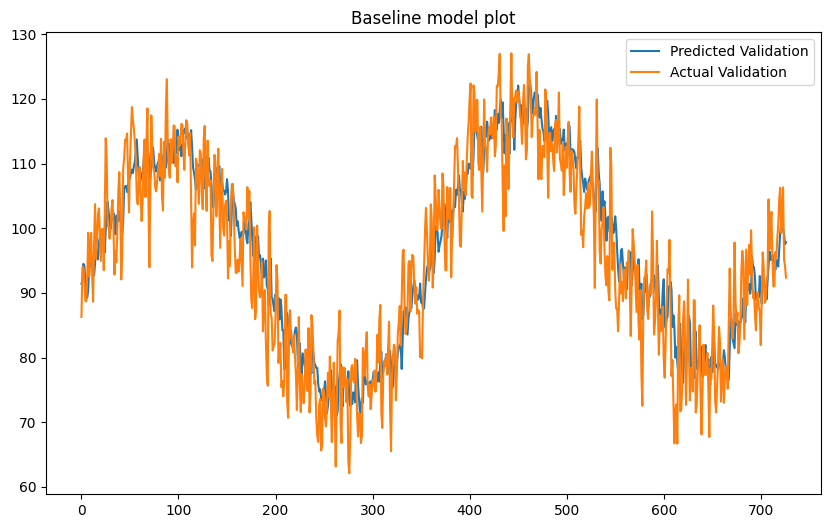

In [13]:
# Model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(window_size,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

#compile the model
model.compile(optimizer='adam', loss='mse')

# Fit model
history = model.fit(train_data, epochs=100, verbose=0)

# Evaluation
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')
# Plotting
plot_predictions(model.predict(X_val), y_val)


23/23 [==============================] - 0s 2ms/step


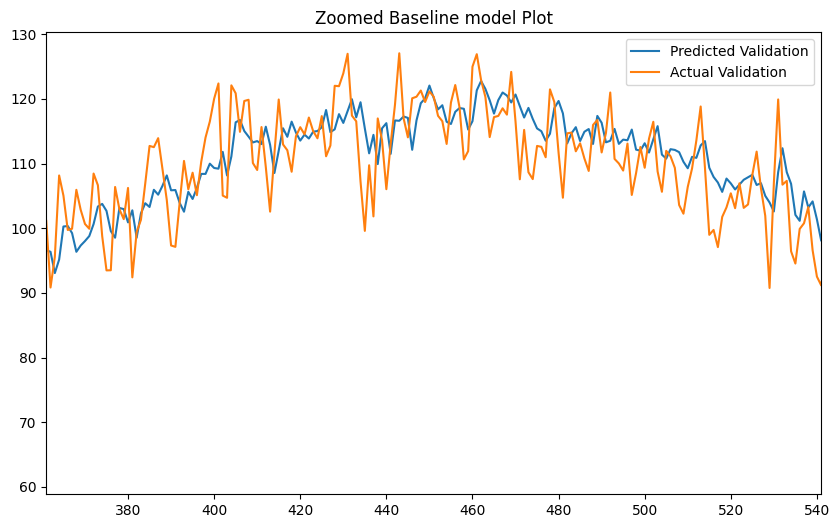

In [14]:
start_date = "2022-01-01"
end_date = "2022-06-30"
plot_predictions(model.predict(X_val), y_val, title="Zoomed Baseline model Plot", start_date=start_date, end_date=end_date)

#Inbuilt learning rate schedulers

23/23 [==============================] - 0s 1ms/step


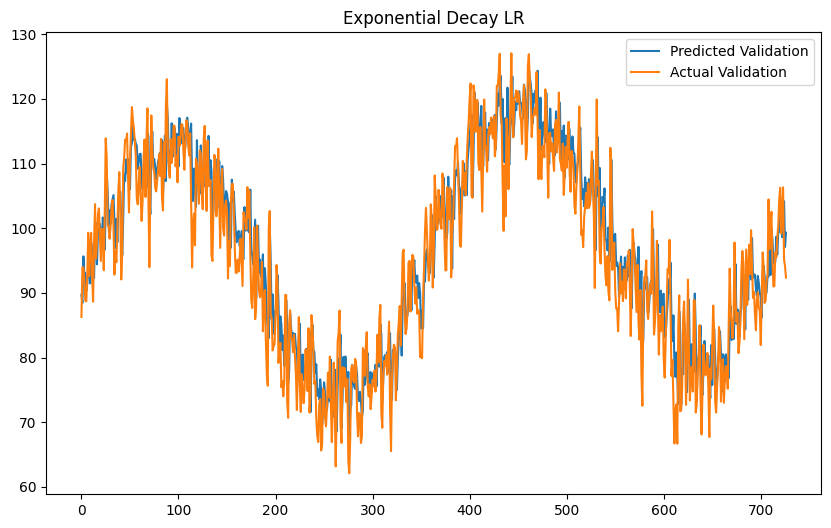

23/23 [==============================] - 0s 4ms/step


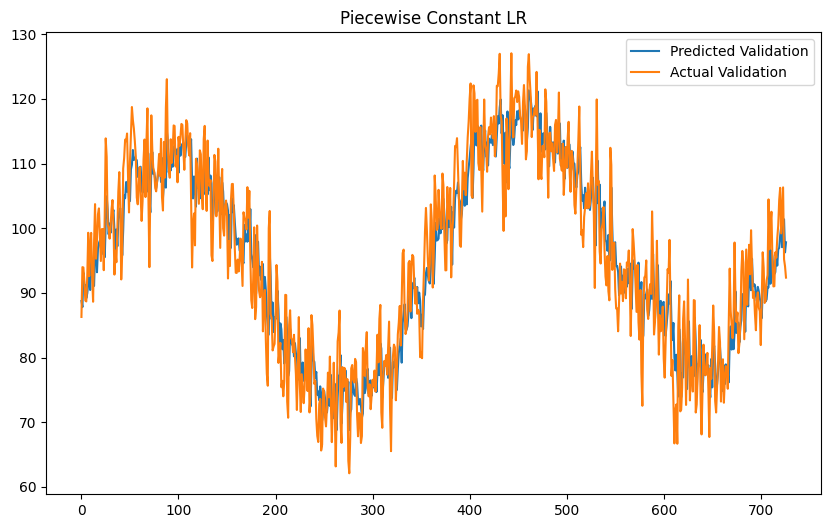

23/23 [==============================] - 0s 2ms/step


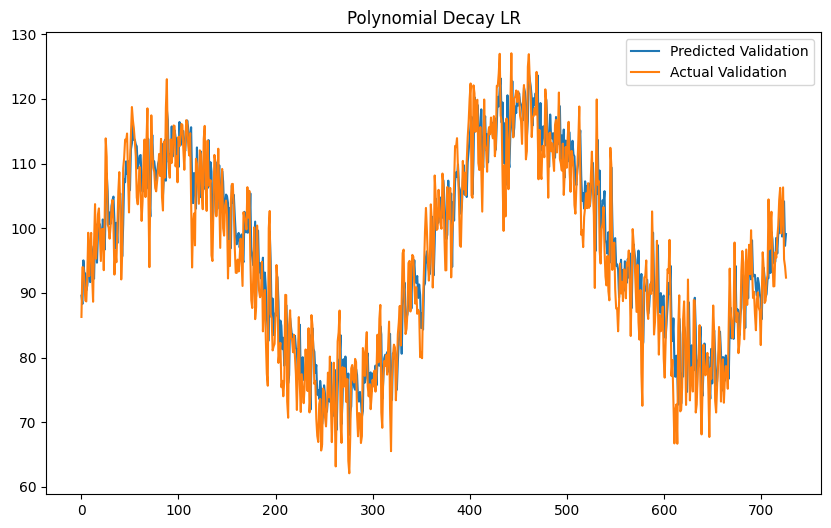

Exponential Decay - MAE: 4.316676628186253, MSE: 29.36735281198587
Piecewise Constant - MAE: 4.286239309192852, MSE: 28.700723104038925
Polynomial Decay - MAE: 4.29481914410073, MSE: 28.99777781777119


In [5]:
def inbuilt_scheduler(model, train_data, X_val, y_val, optimizer, epochs=100, title="Model Performance"):
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(train_data, epochs=epochs, verbose=0)
    forecast_val = model.predict(X_val)
    mae_val, mse_val = evaluate_model(model, X_val, y_val)
    plot_predictions(forecast_val, y_val, title=title)

    return model, mae_val, mse_val

# Set up learning rate schedules
lr_schedules = {
    'Exponential Decay': tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96),
    'Piecewise Constant': tf.keras.optimizers.schedules.PiecewiseConstantDecay([30, 60], [0.1, 0.01, 0.001]),
    'Polynomial Decay': tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.1, decay_steps=100, end_learning_rate=0.01, power=1.0)
}

results = {}

# Train and evaluate the model for each learning rate schedule
for i, lr_schedule in lr_schedules.items():
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    _, mae, mse = inbuilt_scheduler(model, train_data, X_val, y_val, optimizer, title=i + " LR")
    results[i] = (mae, mse)

# Print the results
for i, (mae, mse) in results.items():
    print(f'{i} - MAE: {mae}, MSE: {mse}')


#Custom learning rate

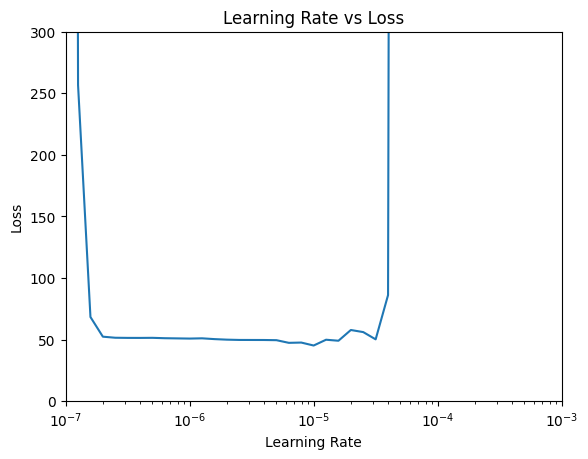

In [6]:
# Model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(window_size,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# Define learning rate schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 10))

# Define optimizer with initial learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Compile model with optimizer and loss
model.compile(optimizer=optimizer, loss='mse')

# Fit model with learning rate schedule callback
history = model.fit(train_data, epochs=200, callbacks=[lr_schedule], verbose=0)

# Plot loss vs learning rate
lrs = 1e-7 * (10 ** (np.arange(200) / 10))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-7, 1e-3, 0, 300])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.show()


#New learning rate

23/23 [==============================] - 0s 2ms/step
MAE: 4.500474262053897, MSE: 31.086601929691355
23/23 [==============================] - 0s 2ms/step


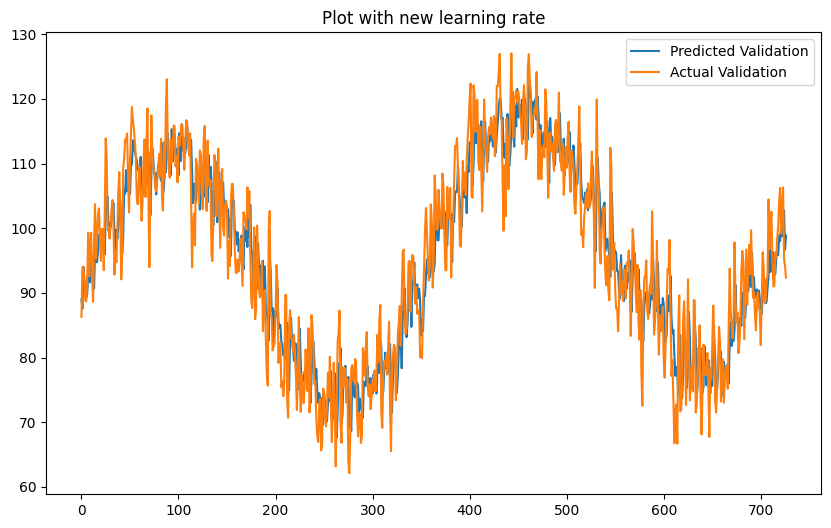

In [9]:
# Model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(window_size,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# Compile model with optimizer and loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-4), loss='mse')

# Fit model
history = model.fit(train_data, epochs=200, verbose=0)

# Evaluation
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')
# Plotting
plot_predictions(model.predict(X_val), y_val, title="Plot with new learning rate")




23/23 [==============================] - 0s 4ms/step


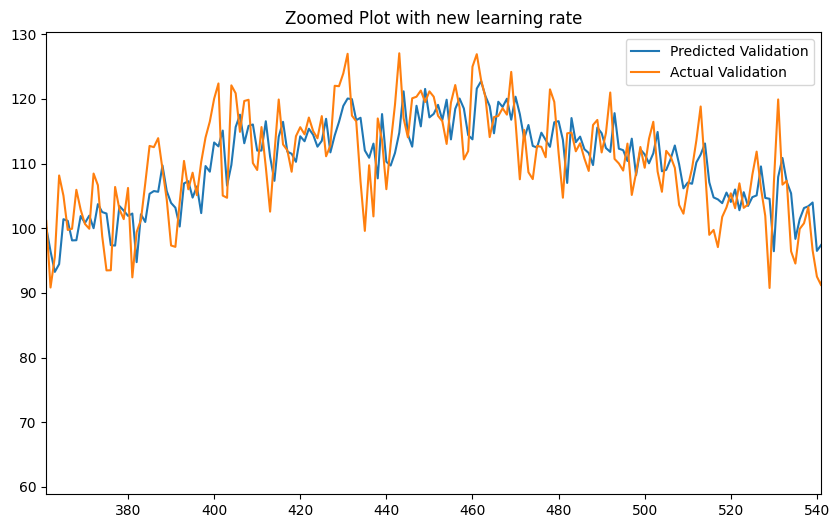

In [10]:
start_date = "2022-01-01"
end_date = "2022-06-30"
plot_predictions(model.predict(X_val), y_val, title="Zoomed Plot with new learning rate", start_date=start_date, end_date=end_date)